# Bi-directional seq2seq using GloVe embeddings, not working yet. 

In [1]:
from attention import AttentionLayer
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
import warnings
import matplotlib.pyplot as plt
%matplotlib
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Using matplotlib backend: TkAgg


In [92]:
data=pd.read_csv("..\\Data\\model_training\\100000_samples_Reviews.csv", nrows=9000)
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na rows

In [93]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [94]:
# data=data.rename(columns = {'article': 'Text', 'title': 'Summary'})
data.head()

,Text,Summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all"
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,Cough Medicine
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Great taffy


In [95]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [96]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [97]:
for i in range(2):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print()

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food 

Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised 



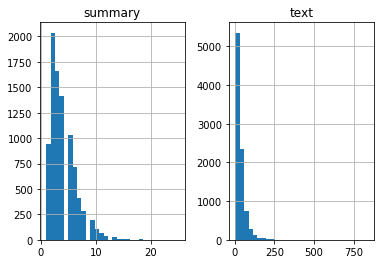

In [98]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [99]:
max_len_text=30
max_len_summary=8

In [100]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [101]:
# Apply start of sentence/ end of sentence tokens to summary, used for 
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok
...,...,...
5086,senseo pods getting harder find especially paris vanilla caramel flavor happy find amazon good price especially subscription price,sostok good coffee for good price eostok
5087,far great way order favorite coffee become really hard find local stores amazon even cheaper previously paid arrived quickly waiting day next shipment,sostok great coffee great price eostok
5088,coffee smell taste great recommend senseo vienna still packages paris nobody wanna drink guess throw away,sostok smells and tastes funny eostok
5089,tried brands french vanilla coffee best highly recommend,sostok best of the best eostok


In [102]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2)

In [103]:
y_val[0:10]

array(['sostok disappointed tough kernals  eostok',
       'sostok excellent exactly what expected  eostok',
       'sostok great deal  eostok', 'sostok the sweet life  eostok',
       'sostok giants sunflower seeds  eostok', 'sostok addicted  eostok',
       'sostok disposakup  eostok', 'sostok good but not special  eostok',
       'sostok great first food  eostok', 'sostok seasonings  eostok'],
      dtype=object)

## X: Text tokenizer

In [104]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4 # threshold = 4. Word whose count is below 4 is considered as a rare word
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.81405563689604
Total Coverage of rare words: 9.880889034423479


In [105]:
tot_cnt-cnt

2343

In [106]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # for the vocabulary
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

2344

In [107]:
x_tr

array([[ 11, 565, 259, ...,   0,   0,   0],
       [316,  18,  60, ...,   0,   0,   0],
       [ 56,  95, 148, ...,   0,   0,   0],
       ...,
       [297, 502,  15, ...,   0,   0,   0],
       [ 62, 313, 494, ...,   0,   0,   0],
       [296,  79, 447, ...,   0,   0,   0]])

In [108]:
x_tr.shape

(4072, 30)

## Y: Summary Tokenizer

In [109]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6 # threshold = 6. Word whose count is below 6 is considered as a rare word, since summaries are less.
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 85.25073746312685
Total Coverage of rare words: 15.611497275972198


In [110]:
tot_cnt-cnt

350

In [111]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

351

In [112]:
y_tokenizer.word_counts['sostok']-len(y_tr) # should be 0, check if there are any sostok's in the word list. 

0

In [113]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [114]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Testing New Tokenization method,
uses a smaller VOCAB_SIZE instead of finding the "right" number of words.

trains using all data instead of train/validation.

In [146]:
# np.array(df['text']),np.array(df['summary']),test_size=0.2
VOCAB_SIZE=299

# Text
text_tokenizer = Tokenizer(num_words=VOCAB_SIZE) # for the vocabulary
text_tokenizer.fit_on_texts(list(df.text))
text_sequences=text_tokenizer.texts_to_sequences(list(df.text))
text_word_index=text_tokenizer.word_index

text_word_index_300={}
counter = 0
for word in text_word_index.keys():
    if text_word_index[word] == 0:
        print("found 0!")
        break
    if text_word_index[word] > VOCAB_SIZE:
        continue
    else:
        text_word_index_300[word] = text_word_index[word]
        counter += 1
print(counter)

# Summaries
sum_tokenizer = Tokenizer(num_words=VOCAB_SIZE) # for the vocabulary
sum_tokenizer.fit_on_texts(list(df.summary))
target_word_index=sum_tokenizer.word_index

sum_word_index_300={}
counter = 0
for word in sum_word_index.keys():
    if sum_word_index[word] == 0:
        print("found 0!")
        break
    if sum_word_index[word] > VOCAB_SIZE:
        continue
    else:
        sum_word_index_300[word] = sum_word_index[word]
        counter += 1
print(counter)
# should produce counter=VOCAB_SIZE=299 twice. 

299
299


In [192]:
dict(islice(sum_word_index_300.items(), 10))

{'sostok': 1,
 'eostok': 2,
 'great': 3,
 'good': 4,
 'the': 5,
 'best': 6,
 'coffee': 7,
 'for': 8,
 'not': 9,
 'love': 10}

## Pad sequences

In [147]:
from keras.preprocessing.sequence import pad_sequences
max_len_text=30
max_len_summary=8
text_sequences=text_tokenizer.texts_to_sequences(list(df.text))
sum_sequences=sum_tokenizer.texts_to_sequences(list(df.summary))

pad_text_sequences = pad_sequences(text_sequences, maxlen=max_len_text, padding='post', truncating='post')
pad_sum_sequences = pad_sequences(sum_sequences, maxlen=max_len_summary, padding='post', truncating='post')
print(len(text_sequences[1]), len(pad_text_sequences[1]))
print(pad_text_sequences.shape)
pad_text_sequences

6 30
(5091, 30)


array([[ 39, 215,  62, ...,   0,   0,   0],
       [  6, 127, 180, ...,   0,   0,   0],
       [128,  41,  67, ...,   0,   0,   0],
       ...,
       [  4, 248,   7, ...,   0,   0,   0],
       [ 22, 159, 200, ...,   0,   0,   0],
       [ 49,   8,   1, ...,   0,   0,   0]])

## GloVe embeddings

In [148]:
from load_glove_embeddings import load_glove_embeddings # local function from .py file
glove_dimension = 50
import time
timer_start = time.time()
# word2index, embedding_matrix = load_glove_embeddings('Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
word2index, embedding_matrix = load_glove_embeddings('../Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)

print('Found %s word vectors.' % len(word2index))
print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
del timer_start

Found 400000 word vectors.
Creating embeddings_index took 13.2 seconds.


In [149]:
embedding_matrix

array([[ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.013441  ,  0.23682   , -0.16899   , ..., -0.56656998,
         0.044691  ,  0.30392   ],
       [ 0.15164   ,  0.30177   , -0.16763   , ..., -0.35652   ,
         0.016413  ,  0.10216   ],
       ...,
       [-0.51181   ,  0.058706  ,  1.09130001, ..., -0.25003001,
        -1.125     ,  1.58630002],
       [-0.75897998, -0.47426   ,  0.47369999, ...,  0.78953999,
        -0.014116  ,  0.64480001],
       [ 0.072617  , -0.51393002,  0.47279999, ..., -0.18907   ,
        -0.59021002,  0.55558997]])

In [150]:
from itertools import islice
list(islice(word2index.items(), 10))

[('the', 0),
 (',', 1),
 ('.', 2),
 ('of', 3),
 ('to', 4),
 ('and', 5),
 ('in', 6),
 ('a', 7),
 ('"', 8),
 ("'s", 9)]

In [151]:
def embedding_matrix_creater(embedding_dimention, word_index): 
    """
    Uses GloVe as a global word embedding. 
    
    embedding_dimention: usually in the title of glove.6D.'embedding_dimention', in this notebook use 50. 
    word_index: the input word embeddings
    
    returns: a local embedding matrix, to be input as weights [embedding] for the constructor
        for keras' Embedding object. 
    """
    local_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = word2index.get(word) # from cell above, from glove.
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            local_embedding_matrix[i] = embedding_vector
    return local_embedding_matrix

In [119]:
# from tensorflow.keras.layers import Embedding
# text_embedding_matrix = embedding_matrix_creater(glove_dimension, 
#         word_index=dict(islice(x_tokenizer.word_index.items(), x_tokenizer.num_words+1)))
# print(text_embedding_matrix.shape)

# sum_embedding_matrix = embedding_matrix_creater(glove_dimension, 
#         word_index=dict(islice(y_tokenizer.word_index.items(), y_tokenizer.num_words+1)))
# print(sum_embedding_matrix.shape)

# encoder_embedding_layer = Embedding(input_dim = text_embedding_matrix.shape[0], # vocab size
#                                     output_dim = text_embedding_matrix.shape[1], # embedding dimension
#                                     input_length = max_len_text, # sequence length
#                                     weights = [text_embedding_matrix],
#                                     trainable = False) # False because these embeddings have already been trained. 

# decoder_embedding_layer = Embedding(input_dim = sum_embedding_matrix.shape[0],
#                                     output_dim = sum_embedding_matrix.shape[1],
#                                     input_length = max_len_summary,
#                                     weights = [sum_embedding_matrix],
#                                     trainable = False) # False because these embeddings have already been trained. 

(2345, 50)
(352, 50)


In [152]:
from tensorflow.keras.layers import Embedding
text_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=text_word_index_300)
print(text_embedding_matrix.shape)

sum_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=sum_word_index_300)
print(sum_embedding_matrix.shape)

encoder_embedding_layer = Embedding(input_dim = text_embedding_matrix.shape[0], # vocab size
                                    output_dim = text_embedding_matrix.shape[1], # embedding dimension
                                    input_length = max_len_text, # sequence length
                                    weights = [text_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

decoder_embedding_layer = Embedding(input_dim = sum_embedding_matrix.shape[0],
                                    output_dim = sum_embedding_matrix.shape[1],
                                    input_length = max_len_summary,
                                    weights = [sum_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

(300, 50)
(300, 50)


In [153]:
sum_embedding_matrix

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [ 1275.,  1275.,  1275., ...,  1275.,  1275.,  1275.],
       [11239., 11239., 11239., ..., 11239., 11239., 11239.],
       [ 2069.,  2069.,  2069., ...,  2069.,  2069.,  2069.]])

In [154]:
text_embedding_matrix

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [ 353.,  353.,  353., ...,  353.,  353.,  353.],
       [ 219.,  219.,  219., ...,  219.,  219.,  219.],
       ...,
       [3978., 3978., 3978., ..., 3978., 3978., 3978.],
       [5652., 5652., 5652., ..., 5652., 5652., 5652.],
       [ 934.,  934.,  934., ...,  934.,  934.,  934.]])

## Base model

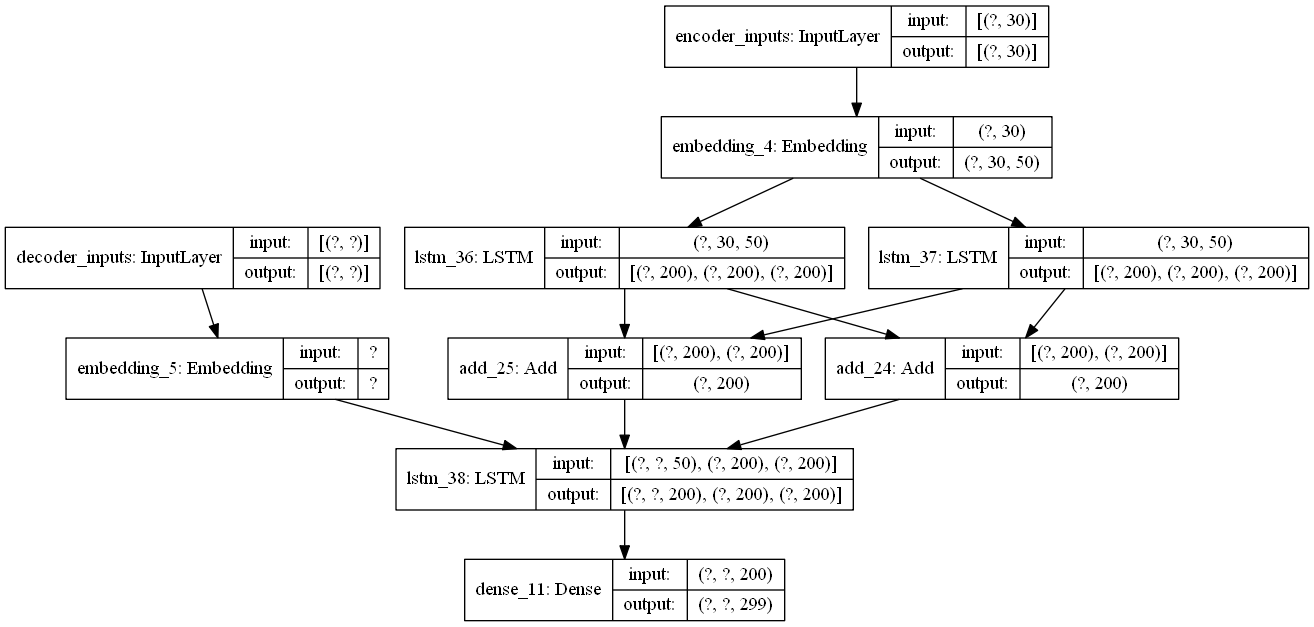

In [255]:
"""
Bidirectional LSTM: Others Inspired Encoder-Decoder-seq2seq
"""
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout,  Dense, Activation,Add, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

HIDDEN_UNITS=200
encoder_inputs = Input(shape=(max_len_text,), name='encoder_inputs')
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

"""
decoder
"""
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
decoder_dense = Dense(sum_embedding_matrix.shape[0]-1, activation='linear') # 300 - 1
decoder_outputs = decoder_dense(decoder_outputs)

model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)
# plot the model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Compile + Train Model

# NEW

In [256]:
num_samples = len(pad_sum_sequences)
decoder_output_data = np.zeros((num_samples, max_len_summary, VOCAB_SIZE), dtype="int32")

In [257]:
for i, seqs in enumerate(pad_sum_sequences):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1

In [258]:
from sklearn.model_selection import train_test_split
art_train, art_test, sum_train, sum_test = train_test_split(pad_text_sequences, pad_sum_sequences, test_size=0.2)
# X_train, X_test, y_train, y_test

In [259]:
train_num = art_train.shape[0]
train_num

4072

In [260]:
target_train = decoder_output_data[:train_num]
target_test = decoder_output_data[train_num:]
target_train.shape

(4072, 8, 299)

In [261]:
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(lr=0.01, clipnorm=1.)
model.compile(loss='mse', optimizer=rmsprop, metrics=["accuracy"])

In [262]:
history = model.fit([art_train, sum_train], 
                     target_train, 
                     epochs=1, # will implement early stopping, see callbacks. 
                     batch_size=32,
#                      callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
                     validation_data=([art_test, sum_test], target_test))

Train on 4072 samples, validate on 1019 samples
4072/4072 [==============================] - 22s 6ms/sample - loss: 0.0079 - accuracy: 0.5098 - val_loss: 0.0019 - val_accuracy: 0.5867


In [263]:
# # model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# from tensorflow.keras.optimizers import RMSprop
# rmsprop = RMSprop(lr=0.01, clipnorm=1.)
# model.compile(loss='mse', optimizer=rmsprop, metrics=["accuracy"])
# # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
# history=model.fit([x_tr,y_tr[:,:-1]], 
#                   y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
#                   epochs=10,
# #                   callbacks=[es],
#                   batch_size=32, 
#                   validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [264]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [265]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
# history=model.fit([x_tr,y_tr[:,:]], 
#                   y_tr.reshape(1,y_tr.shape[0],y_tr.shape[1], 1)[:,:],
#                   epochs=2,
#                   callbacks=[es],
#                   batch_size=128,
#                   validation_data=([x_val,y_val[:,:]], y_val.reshape(1,y_val.shape[0],y_val.shape[1], 1)[:,:]))

## Inference Model

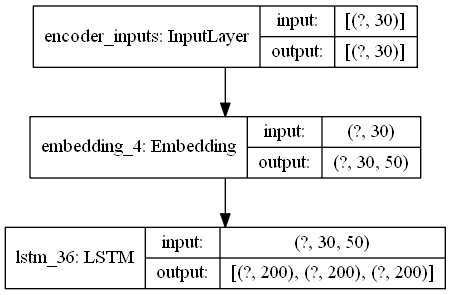

In [266]:
# define encoder inference model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
tf.keras.utils.plot_model(encoder_model, to_file='encoder_model_bi.png', show_shapes=True)

In [273]:
decoder_embedding

<tf.Tensor 'embedding_5_7/Identity:0' shape=(None, None, 50) dtype=float32>

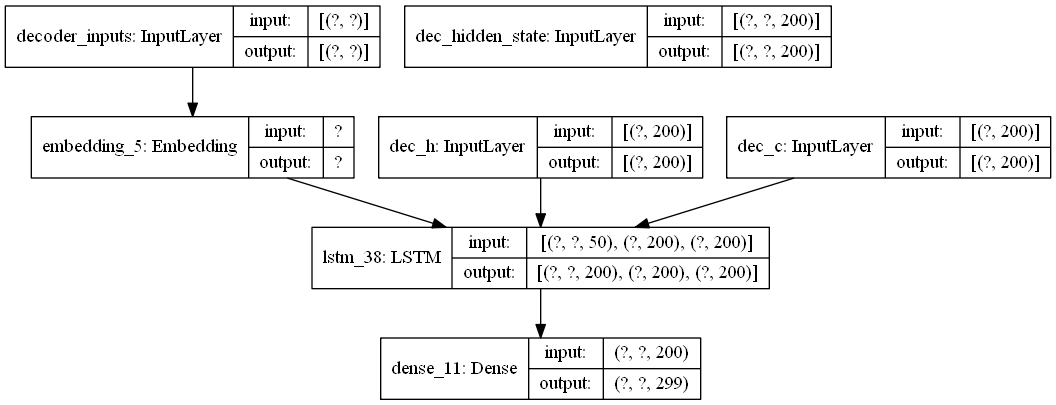

In [268]:
# define decoder inference model
decoder_state_input_h = Input(shape=(HIDDEN_UNITS,), name='dec_h')
decoder_state_input_c = Input(shape=(HIDDEN_UNITS,), name='dec_c')
decoder_hidden_state_input = Input(shape=(None,HIDDEN_UNITS), name='dec_hidden_state') # encoder output

decoder_outputs, state_h, state_c = decoder_LSTM(decoder_embedding, 
                                initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h,decoder_state_input_c], 
    [decoder_outputs] + [state_h, state_c])
tf.keras.utils.plot_model(decoder_model, to_file='decoder_model_bi.png', show_shapes=True)

In [269]:
reverse_target_word_index=sum_tokenizer.index_word 
reverse_source_word_index=text_tokenizer.index_word 
target_word_index=sum_tokenizer.word_index

In [270]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [271]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    print('input_seq.shape:', input_seq.shape)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    e_out=e_out.reshape(1,1,200)
    print('e_out:', e_out[0][0][0])
    print('e_h:', e_h[0][0])
    print('e_c:', e_c[0][0])
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']
    # works fine
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
#         print("output_tokens:", output_tokens)
    
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(sampled_token_index)
#         if sampled_token_index != 0: # loops here too many times, shouldn't have an index of 0, but consistently does. 
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [272]:
for i in range(0,20):
    print("Review:",seq2text(art_train[i]))
    print("Original summary:",seq2summary(sum_train[i]))
    print()
    print("Predicted summary:",decode_sequence(art_train[i].reshape(1,max_len_text)))
    print("________________________________________________________")
    print("\n")

Review: looking good tasting flavor awesome flavor size price would recommend anyone hard find find good 
Original summary: not your seeds 

input_seq.shape: (1, 30)
e_out: 0.884354
e_h: 0.884354
e_c: 2.9148812
Predicted summary:  bit real if deal deal deal deal
________________________________________________________


Review: wonderful natural flavor great little sweet treat want something bad delicious 
Original summary: delicious 

input_seq.shape: (1, 30)
e_out: 0.88420963
e_h: 0.88420963
e_c: 2.9807584


KeyError: 0

In [ ]:
# for i in range(1,20):
#     print("Review:",seq2text(x_tr[i]))
#     print("Original summary:",seq2summary(y_tr[i]))
#     print()
#     print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
#     print("________________________________________________________")
#     print("\n")